In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class WTU(object):    
    def __init__(self, m, n, dim, num_iterations, eta = 0.5, sigma = None):
        
        self._m = m
        self._n = n
        self._neighbourhood = []
        self._topography = []
        self._num_iterations = int(num_iterations) 
        self._learned = False
        self.dim = dim
        
        self.eta = float(eta)
           
        if sigma is None:
            sigma = max(m,n)/2.0
        else:
            sigma = float(sigma)
        self.sigma = sigma
        
        print('Network created with dimensions',m,n)
            
        self._W = tf.random.normal([m*n, dim], seed = 0)
        self._topography = np.array(list(self._neuron_location(m, n)))
        
    def training(self,x, i):
            m = self._m
            n= self._n 
            
            d = tf.sqrt(tf.reduce_sum(tf.pow(self._W - tf.stack([x for i in range(m*n)]),2),1))
            self.WTU_idx = tf.argmin(d,0)
            
            slice_start = tf.pad(tf.reshape(self.WTU_idx, [1]),np.array([[0,1]]))
            self.WTU_loc = tf.reshape(tf.slice(self._topography, slice_start,[1,2]), [2])
        
            learning_rate = 1 - i/self._num_iterations
            _eta_new = self.eta * learning_rate
            _sigma_new = self.sigma * learning_rate
            
            distance_square = tf.reduce_sum(tf.pow(tf.subtract(self._topography, tf.stack(
                [self.WTU_loc for i in range(m * n)])), 2), 1)
            neighbourhood_func = tf.exp(tf.negative(tf.math.divide(tf.cast(
                distance_square, "float32"), tf.pow(_sigma_new, 2))))
            
            eta_into_Gamma = tf.multiply(_eta_new, neighbourhood_func)
            
            weight_multiplier = tf.stack([tf.tile(tf.slice(
                eta_into_Gamma, np.array([i]), np.array([1])), [self.dim]) for i in range(m * n)])
            delta_W = tf.multiply(weight_multiplier, tf.subtract(tf.stack([x for i in range(m * n)]),self._W))
            new_W = self._W + delta_W
            self._W = new_W
            
    def fit(self, X):
        for i in range(self._num_iterations):
            for x in X:
                 self.training(x,i)
            
        centroid_grid = [[] for i in range(self._m)]
        self._Wts = list(self._W)
        self._locations = list(self._topography)
        
        for i, loc in enumerate(self._locations):
            centroid_grid[loc[0]].append(self._Wts[i])
        self._centroid_grid = centroid_grid

        self._learned = True
    
    def winner(self, x):
        idx = self.WTU_idx,self.WTU_loc
        return idx
             
    def _neuron_location(self,m,n):
        for i in range(m):
            for j in range(n):
                yield np.array([i,j])
                
                
    def get_centroids(self):
        if not self._learned:
            raise ValueError("SOM not trained yet")
        return self._centroid_grid

    def map_vects(self, X):
        if not self._learned:
            raise ValueError("SOM not trained yet")

        to_return = []
        for vect in X:
            min_index = min([i for i in range(len(self._Wts))],
                            key=lambda x: np.linalg.norm(vect - self._Wts[x]))
            to_return.append(self._locations[min_index])

        return to_return

In [3]:
def normalize(df):
    result = df.copy()
    
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        
    return result.astype(np.float32)

In [4]:
import pandas as pd

df = pd.read_csv('colors.csv')
data = normalize(df[['R', 'G', 'B']]).values
name = df['Color-Name'].values
n_dim = len(df.columns) - 1

In [5]:
colors = data
color_names = name

In [6]:
som = WTU(30, 30, n_dim, 400, sigma=10.0)
som.fit(colors)

Network created with dimensions 30 30


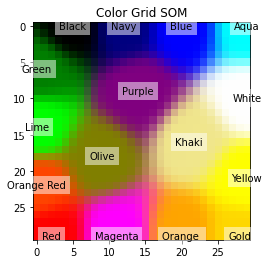

In [7]:
image_grid = som.get_centroids()

mapped = som.map_vects(colors)

plt.imshow(image_grid)
plt.title('Color Grid SOM')

for i, m in enumerate(mapped):
    plt.text(m[1], m[0], color_names[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))

In [8]:
idx, loc = som.winner([0.5, 0.5, 0.5])
print(idx, loc)

tf.Tensor(501, shape=(), dtype=int64) tf.Tensor([16 21], shape=(2,), dtype=int32)
